# IMPORT LIBRARY

In [2]:
# !pip cache purge
# !pip install catboost

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import learning_curve
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor, plot_importance as lgb_plot_importance
from catboost import CatBoostRegressor, Pool

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# LOAD DATASET

In [5]:
# df_1300 = pd.read_csv('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UAS - Project 2/medical1300.csv')
# df_900 = pd.read_csv('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UAS - Project 2/medical900.csv')
df_1300 = pd.read_csv('dataset/medical1300.csv')
df_900 = pd.read_csv('dataset/medical900.csv')
df_900.shape,df_1300.shape

((986, 11), (1338, 7))

In [6]:
df_1300.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
df_900.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


# PREPROCESSING

In [8]:
medical900 = df_900.copy()
medical1300 = df_1300.copy()

In [9]:
# Define a function for preprocessing
def preprocess_data(df, target_column):
    # Check for missing values
    if df.isnull().sum().sum() > 0:
        df = df.dropna()

    # Check for duplicate values
    df = df.drop_duplicates()

    # Split features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # One-hot encoding for categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Feature scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y

# Preprocess the datasets
X_1300, y_1300 = preprocess_data(medical1300, 'charges')
X_900, y_900 = preprocess_data(medical900, 'PremiumPrice')

# Split the data into training and testing sets
X_train_1300, X_test_1300, y_train_1300, y_test_1300 = train_test_split(X_1300, y_1300, test_size=0.2, random_state=42)
X_train_900, X_test_900, y_train_900, y_test_900 = train_test_split(X_900, y_900, test_size=0.2, random_state=42)

# MODELIING

## LIGHTGBM

### Training & Evaluate

In [13]:
def evaluate_lightgbm(X_train, X_test, y_train, y_test):
    model = LGBMRegressor(verbose=0)

    param_grid = {
        'n_estimators': [50, 100, 200, 300, 400, 500],
        'learning_rate': [0.1, 0.01, 0.001],
        'num_leaves': [20, 25, 30, 35, 40],
        'min_child_weight': [1, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Best Params': grid_search.best_params_
    }

    return results

# Evaluate LightGBM model on both datasets
lgbm_results_1300 = evaluate_lightgbm(X_train_1300, X_test_1300, y_train_1300, y_test_1300)
lgbm_results_900 = evaluate_lightgbm(X_train_900, X_test_900, y_train_900, y_test_900)

# Display the results
print("Light GBM Hyperpamater Tuning using Grid Search")
print("Results for medical1300.csv:")
for metric, value in lgbm_results_1300.items():
    print(f"{metric}: {value}")

print("\nResults for medical900.csv:")
for metric, value in lgbm_results_900.items():
    print(f"{metric}: {value}")

Light GBM Hyperpamater Tuning using Grid Search
Results for medical1300.csv:
MAE: 2487.403038894519
MSE: 18786321.698770154
RMSE: 4334.319058257035
R2: 0.8977648884851585
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 400, 'num_leaves': 20, 'subsample': 0.6}

Results for medical900.csv:
MAE: 1286.1239102766392
MSE: 4679434.273504807
RMSE: 2163.2000077442694
R2: 0.8902643541098512
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 500, 'num_leaves': 20, 'subsample': 0.6}


### Save & Load Metrics

In [ ]:
import pickle

# Save lgbm_results_1300
with open('metrics/LightGBM_results_1300.pkl', 'wb') as f:
    pickle.dump(lgbm_results_1300, f)

# Save lgbm_results_900
with open('metrics/LightGBM_results_900.pkl', 'wb') as f:
    pickle.dump(lgbm_results_900, f)

In [38]:
# load the model from disk
lgbm_metrics = pickle.load(open('metrics/LightGBM_results_1300.pkl', 'rb'))
print(lgbm_metrics)

# load the model from disk
lgbm_metrics = pickle.load(open('metrics/LightGBM_results_900.pkl', 'rb'))
print(lgbm_metrics)

{'MAE': 2487.403038894519, 'MSE': 18786321.698770154, 'RMSE': 4334.319058257035, 'R2': 0.8977648884851585, 'Best Params': {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 400, 'num_leaves': 20, 'subsample': 0.6}}
{'MAE': 1286.1239102766392, 'MSE': 4679434.273504807, 'RMSE': 2163.2000077442694, 'R2': 0.8902643541098512, 'Best Params': {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 500, 'num_leaves': 20, 'subsample': 0.6}}


### Learning Curve

In [16]:
# Retrieve the best models from GridSearchCV for medical1300 & medical900 dataset
lgbm_best_1300 = LGBMRegressor(**lgbm_results_1300['Best Params'])
lgbm_best_900 = LGBMRegressor(**lgbm_results_900['Best Params'])

# Fit models with the best hyperparameters for medical1300 and medical900 dataset
lgbm_best_1300.fit(X_train_1300, y_train_1300)
lgbm_best_900.fit(X_train_900, y_train_900)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 8
[LightGBM] [Info] Start training from score 13030.203373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 788, number of used features: 10
[LightGBM] [Info] Start training from score 24269.035533


LGBMRegressor(learning_rate=0.01, min_child_weight=1, n_estimators=500,
              num_leaves=20, subsample=0.6)

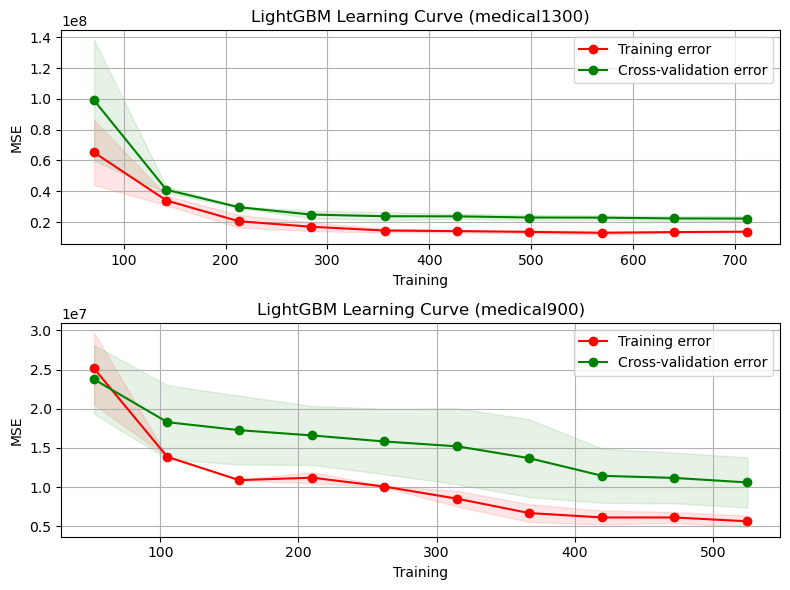

In [25]:
# Function to plot learning curves
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    plt.title(title)
    plt.xlabel("Training")
    plt.ylabel("MSE")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation error")

    plt.legend(loc="best")
    return plt

plt.figure(figsize=(8, 6))
# Plot learning curves for each model on the medical1300 dataset
plt.subplot(2,1,1)
plot_learning_curve(lgbm_best_1300, X_train_1300, y_train_1300, "LightGBM Learning Curve (medical1300)")

# Plot learning curves for each model on the medical900 dataset
plt.subplot(2,1,2)
plot_learning_curve(lgbm_best_900, X_train_900, y_train_900, "LightGBM Learning Curve (medical900)")

plt.tight_layout()
plt.show()

### Plot Feature Importane

In [18]:
# Retrieve feature names after preprocessing
feature_names_1300 = pd.get_dummies(medical1300.drop(columns=['charges']), drop_first=True).columns
feature_names_900 = pd.get_dummies(medical900.drop(columns=['PremiumPrice']), drop_first=True).columns

# Plot feature importance for XGBoost with proper feature names
def plot_xgb_importance(model, feature_names, title):
    importance = model.get_booster().get_score(importance_type='weight')
    importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Score'])
    importance_df['Feature'] = importance_df['Feature'].apply(lambda x: feature_names[int(x[1:])])
    importance_df = importance_df.sort_values(by='Score', ascending=False)

    # plt.figure(figsize=(10, 8))
    sns.barplot(x='Score', y='Feature', data=importance_df)
    plt.title(title)
    # plt.show()

# Plot feature importance for LightGBM with proper feature names
def plot_lgb_importance(model, feature_names, title):
    importance = model.booster_.feature_importance(importance_type='split')
    importance_df = pd.DataFrame({'Feature': feature_names, 'Score': importance})
    importance_df = importance_df.sort_values(by='Score', ascending=False)

    # plt.figure(figsize=(10, 8))
    sns.barplot(x='Score', y='Feature', data=importance_df)
    plt.title(title)
    # plt.show()


# Plot feature importance for CatBoost with proper feature names
def plot_catboost_importance(model, feature_names, title):
    feature_importances = model.get_feature_importance()
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
    plt.title(title)
    # plt.show()

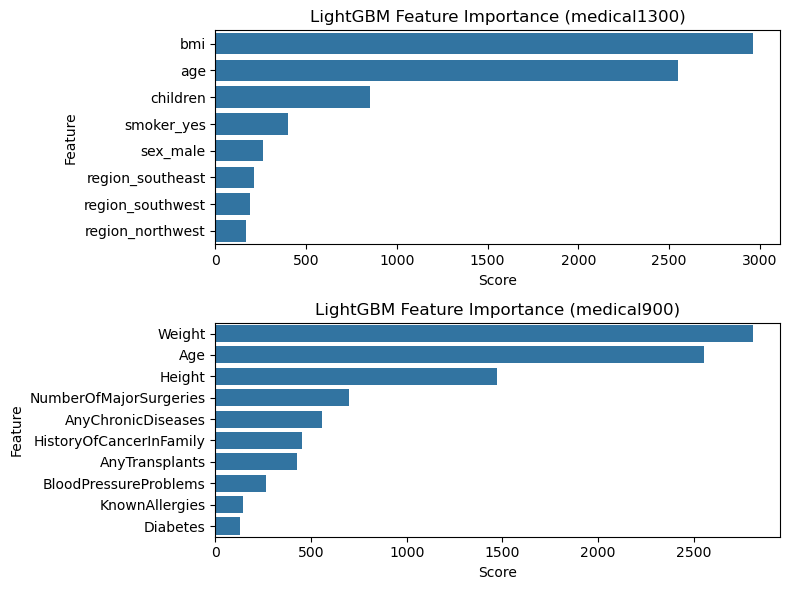

In [24]:
plt.figure(figsize=(8, 6))

plt.subplot(2,1,1)
plot_lgb_importance(lgbm_best_1300, feature_names_1300, 'LightGBM Feature Importance (medical1300)')

plt.subplot(2,1,2)
plot_lgb_importance(lgbm_best_900, feature_names_900, 'LightGBM Feature Importance (medical900)')

plt.tight_layout()
plt.show()

## MODEL FOR COMPARISON

### Training & Evaluate

In [102]:
def evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'SVM': SVR(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(),
        'AdaBoost': AdaBoostRegressor(),
        'Gradient Boosting': GradientBoostingRegressor(),
        'XGBoost': XGBRegressor(verbosity=0),
        'CatBoost': CatBoostRegressor(verbose=0)
    }

    param_grids = {
        'Linear Regression': {},
        'SVM': {
            'C': [0.1, 1, 10],
            'epsilon': [0.1, 0.01, 0.001],
            'kernel': ['linear']
        },
        'Decision Tree': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10]
        },
        'Random Forest': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [None, 10, 20, 30],
            'max_leaf_nodes': [3, 6, 9],
        },
        'AdaBoost': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.01, 0.001]
        },
        'Gradient Boosting': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.01, 0.001],
            'max_depth':  [2, 3, 5, 7],
        },
        'XGBoost': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.01, 0.001],
            'max_depth':  [2, 3, 5, 7],
        },
        'CatBoost': {
            'iterations': [50, 100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.01, 0.001],
            'depth':  [2, 3, 5, 7],
        }
    }

    results = {}

    for name, model in models.items():
        if name in param_grids:
            grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        else:
            grid_search = GridSearchCV(model, {}, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'Best Params': grid_search.best_params_ if name in param_grids else 'No hyperparameters tuned'
        }

    return results

# Evaluate models on both datasets
results_1300 = evaluate_models(X_train_1300, X_test_1300, y_train_1300, y_test_1300)
results_900 = evaluate_models(X_train_900, X_test_900, y_train_900, y_test_900)

# Display the results
print("Hyperpamater Tuning using Grid Search")
print("Results for medical1300.csv:")
for model, metrics in results_1300.items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

print("\nResults for medical900.csv:")
for model, metrics in results_900.items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")


Hyperpamater Tuning using Grid Search
Results for medical1300.csv:

Linear Regression:
MAE: 4177.045561036322
MSE: 35478020.67523556
RMSE: 5956.3428943635845
R2: 0.8069287081198014
Best Params: {}

SVM:
MAE: 4884.135651804055
MSE: 98234451.27026065
RMSE: 9911.329440103415
R2: 0.46540838375658033
Best Params: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}

Decision Tree:
MAE: 2807.9938111586807
MSE: 24965269.092574947
RMSE: 4996.525702182963
R2: 0.8641390735981853
Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 20}

Random Forest:
MAE: 2627.54453220972
MSE: 18710358.28147357
RMSE: 4325.547165558777
R2: 0.8981782811951786
Best Params: {'max_depth': None, 'max_leaf_nodes': 9, 'n_estimators': 50}

AdaBoost:
MAE: 2756.344975115195
MSE: 19620183.415424414
RMSE: 4429.467622121694
R2: 0.8932270152943844
Best Params: {'learning_rate': 0.001, 'n_estimators': 50}

Gradient Boosting:
MAE: 2504.926780133474
MSE: 18289349.32370987
RMSE: 4276.604882814155
R2: 0.9004694107965

### Save & Load Metrics

In [113]:
# saved each metrics to pickle file
for key, value in results_1300.items():
    with open(f'metrics/{key}_1300.pkl', 'wb') as f:
        pickle.dump(value, f)

for key, value in results_900.items():
    with open(f'metrics/{key}_900.pkl', 'wb') as f:
        pickle.dump(value, f)

In [114]:
# Load the model from disk
linreg_metrics = pickle.load(open('metrics/Linear Regression_1300.pkl', 'rb'))
print(linreg_metrics)

svm_metrics = pickle.load(open('metrics/SVM_1300.pkl', 'rb'))
print(svm_metrics)

dt_metrics = pickle.load(open('metrics/Decision Tree_1300.pkl', 'rb'))
print(dt_metrics)

rf_metrics = pickle.load(open('metrics/Random Forest_1300.pkl', 'rb'))
print(rf_metrics)

ada_metrics = pickle.load(open('metrics/AdaBoost_1300.pkl', 'rb'))
print(ada_metrics)

gb_metrics = pickle.load(open('metrics/Gradient Boosting_1300.pkl', 'rb'))
print(gb_metrics)

xgb_metrics = pickle.load(open('metrics/XGBoost_1300.pkl', 'rb'))
print(xgb_metrics)

catboost_metrics = pickle.load(open('metrics/CatBoost_1300.pkl', 'rb'))
print(catboost_metrics)

{'MAE': 4177.045561036322, 'MSE': 35478020.67523556, 'RMSE': 5956.3428943635845, 'R2': 0.8069287081198014, 'Best Params': {}}
{'MAE': 4884.135651804055, 'MSE': 98234451.27026065, 'RMSE': 9911.329440103415, 'R2': 0.46540838375658033, 'Best Params': {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}}
{'MAE': 2807.9938111586807, 'MSE': 24965269.092574947, 'RMSE': 4996.525702182963, 'R2': 0.8641390735981853, 'Best Params': {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 20}}
{'MAE': 2627.54453220972, 'MSE': 18710358.28147357, 'RMSE': 4325.547165558777, 'R2': 0.8981782811951786, 'Best Params': {'max_depth': None, 'max_leaf_nodes': 9, 'n_estimators': 50}}
{'MAE': 2756.344975115195, 'MSE': 19620183.415424414, 'RMSE': 4429.467622121694, 'R2': 0.8932270152943844, 'Best Params': {'learning_rate': 0.001, 'n_estimators': 50}}
{'MAE': 2504.926780133474, 'MSE': 18289349.32370987, 'RMSE': 4276.604882814155, 'R2': 0.9004694107965916, 'Best Params': {'learning_rate': 0.01, 'max_depth': 3, 'n_e

In [116]:
# Load the model from disk
linreg_metrics = pickle.load(open('metrics/Linear Regression_900.pkl', 'rb'))
print(linreg_metrics)

svm_metrics = pickle.load(open('metrics/SVM_900.pkl', 'rb'))
print(svm_metrics)

dt_metrics = pickle.load(open('metrics/Decision Tree_900.pkl', 'rb'))
print(dt_metrics)

rf_metrics = pickle.load(open('metrics/Random Forest_900.pkl', 'rb'))
print(rf_metrics)

ada_metrics = pickle.load(open('metrics/AdaBoost_900.pkl', 'rb'))
print(ada_metrics)

gb_metrics = pickle.load(open('metrics/Gradient Boosting_900.pkl', 'rb'))
print(gb_metrics)

xgb_metrics = pickle.load(open('metrics/XGBoost_900.pkl', 'rb'))
print(xgb_metrics)

catboost_metrics = pickle.load(open('metrics/CatBoost_900.pkl', 'rb'))
print(catboost_metrics)

{'MAE': 2586.2253840681074, 'MSE': 12221661.705858206, 'RMSE': 3495.949328273825, 'R2': 0.713394427027874, 'Best Params': {}}
{'MAE': 3486.1908274302787, 'MSE': 21435894.754691586, 'RMSE': 4629.89144091863, 'R2': 0.4973149276915644, 'Best Params': {'C': 10, 'epsilon': 0.001, 'kernel': 'linear'}}
{'MAE': 909.9867724867726, 'MSE': 7442690.84218985, 'RMSE': 2728.129550111184, 'R2': 0.8254642679024775, 'Best Params': {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}}
{'MAE': 1780.4324369756746, 'MSE': 6380027.732062756, 'RMSE': 2525.871677671444, 'R2': 0.8503843791675709, 'Best Params': {'max_depth': 10, 'max_leaf_nodes': 9, 'n_estimators': 300}}
{'MAE': 1967.4470850901855, 'MSE': 8504890.964597449, 'RMSE': 2916.3146203037572, 'R2': 0.8005550139875399, 'Best Params': {'learning_rate': 0.001, 'n_estimators': 100}}
{'MAE': 1166.8778179067394, 'MSE': 9610283.792184511, 'RMSE': 3100.0457725950614, 'R2': 0.7746328642558049, 'Best Params': {'learning_rate': 0.01, 'max_depth': 7, 

### Learning Curve

In [117]:
# Retrieve the best models from GridSearchCV for medical1300 dataset
models_1300 = {
    'Linear Regression': LinearRegression(),
    'SVM': SVR(**results_1300['SVM']['Best Params']),
    'Decision Tree': DecisionTreeRegressor(**results_1300['Decision Tree']['Best Params']),
    'Random Forest': RandomForestRegressor(**results_1300['Random Forest']['Best Params']),
    'AdaBoost': AdaBoostRegressor(**results_1300['AdaBoost']['Best Params']),
    'Gradient Boosting': GradientBoostingRegressor(**results_1300['Gradient Boosting']['Best Params']),
    'XGBoost': XGBRegressor(**results_1300['XGBoost']['Best Params']),
    # 'LightGBM': LGBMRegressor(**results_1300['LightGBM']['Best Params']),
    'CatBoost': CatBoostRegressor(verbose=0, **results_1300['CatBoost']['Best Params'])
}

# Retrieve the best models from GridSearchCV for medical900 dataset
models_900 = {
    'Linear Regression': LinearRegression(),
    'SVM': SVR(**results_900['SVM']['Best Params']),
    'Decision Tree': DecisionTreeRegressor(**results_900['Decision Tree']['Best Params']),
    'Random Forest': RandomForestRegressor(**results_900['Random Forest']['Best Params']),
    'AdaBoost': AdaBoostRegressor(**results_900['AdaBoost']['Best Params']),
    'Gradient Boosting': GradientBoostingRegressor(**results_900['Gradient Boosting']['Best Params']),
    'XGBoost': XGBRegressor(**results_900['XGBoost']['Best Params']),
    # 'LightGBM': LGBMRegressor(**results_900['LightGBM']['Best Params']),
    'CatBoost': CatBoostRegressor(verbose=0, **results_900['CatBoost']['Best Params'])
}

# Fit models with the best hyperparameters for medical1300 dataset
for name, model in models_1300.items():
    model.fit(X_train_1300, y_train_1300)

# Fit models with the best hyperparameters for medical900 dataset
for name, model in models_900.items():
    model.fit(X_train_900, y_train_900)

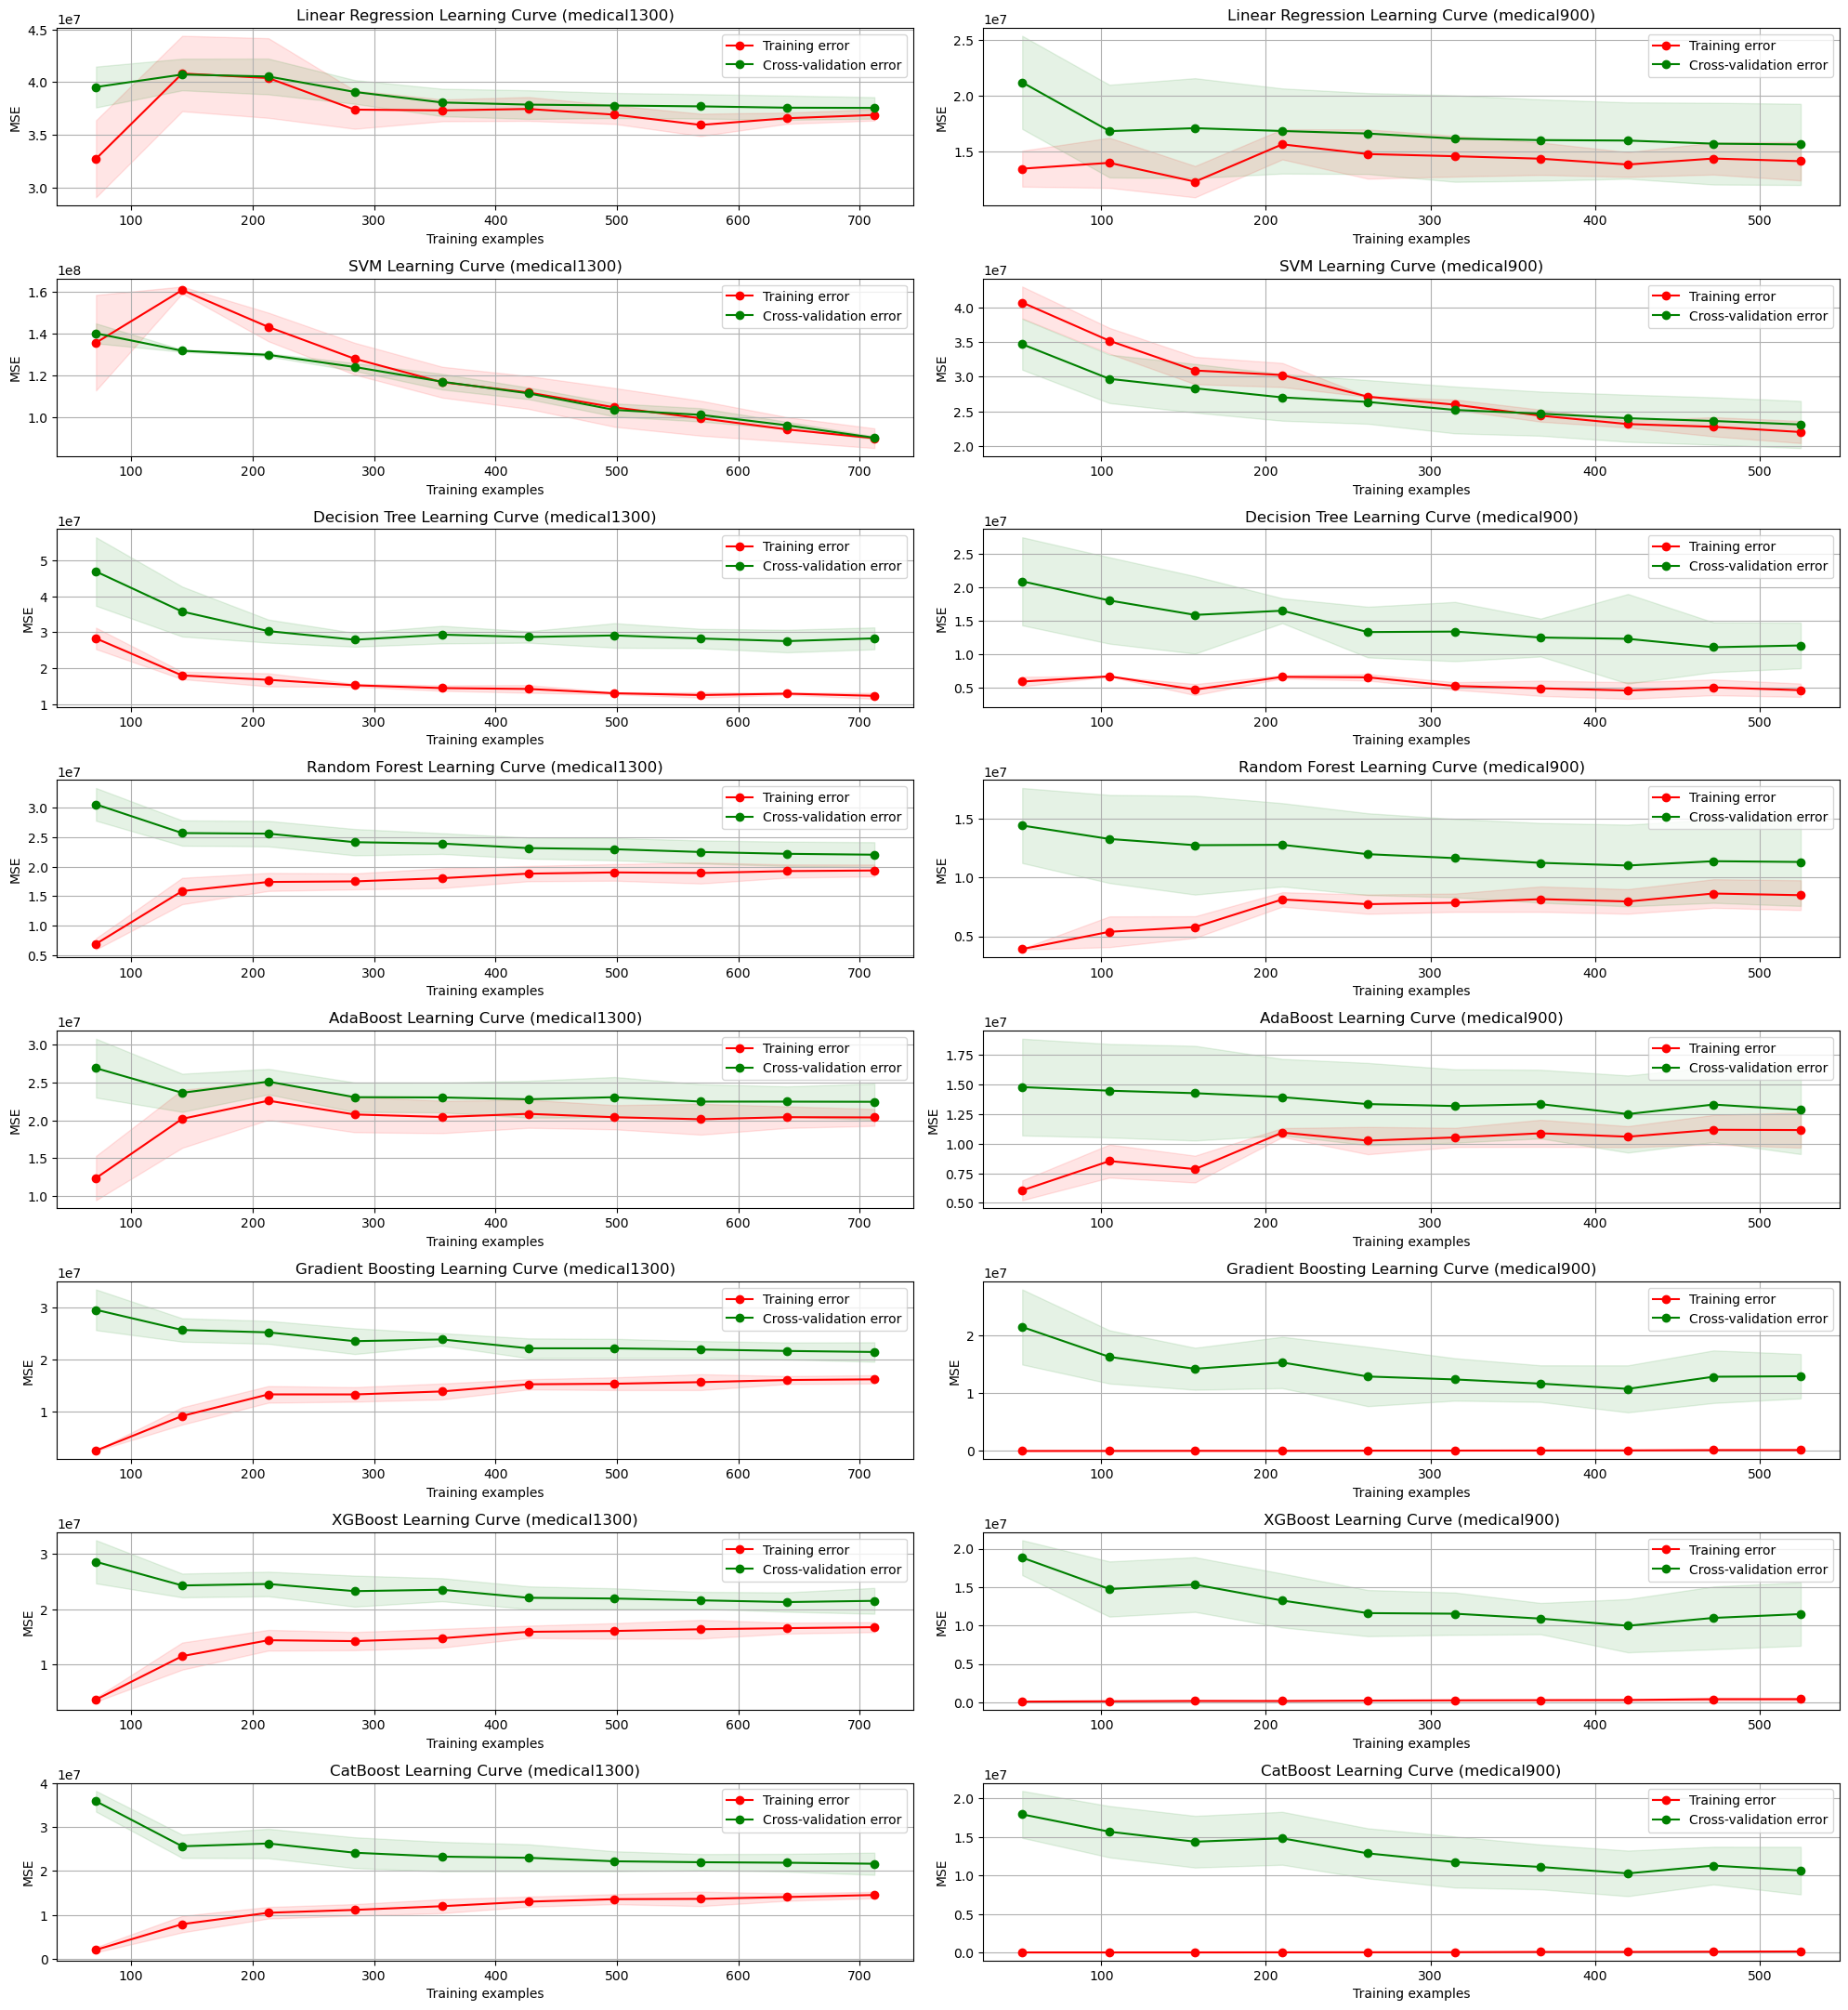

In [118]:
# Function to plot learning curves
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=3, scoring='neg_mean_squared_error', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("MSE")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation error")

    plt.legend(loc="best")
    return plt

plt.figure(figsize=(20, 24))

model_names_1300 = [
    'Linear Regression', 'SVM', 'Decision Tree', 'Random Forest',
    'AdaBoost', 'Gradient Boosting', 'XGBoost', 'CatBoost'
]
for i, name in enumerate(model_names_1300, start=1):
    plt.subplot(9, 2, i * 2 - 1)
    plot_learning_curve(models_1300[name], X_train_1300, y_train_1300, f"{name} Learning Curve (medical1300)")

model_names_900 = [
    'Linear Regression', 'SVM', 'Decision Tree', 'Random Forest',
    'AdaBoost', 'Gradient Boosting', 'XGBoost', 'CatBoost'
]
for i, name in enumerate(model_names_900, start=1):
    plt.subplot(9, 2, i * 2)
    plot_learning_curve(models_900[name], X_train_900, y_train_900, f"{name} Learning Curve (medical900)")

plt.tight_layout()
plt.show()

### Plot Feature Importance
-If the model has the function

In [119]:
# Retrieve feature names after preprocessing
feature_names_1300 = pd.get_dummies(medical1300.drop(columns=['charges']), drop_first=True).columns
feature_names_900 = pd.get_dummies(medical900.drop(columns=['PremiumPrice']), drop_first=True).columns

# Plot feature importance for XGBoost with proper feature names
def plot_xgb_importance(model, feature_names, title):
    importance = model.get_booster().get_score(importance_type='weight')
    importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Score'])
    importance_df['Feature'] = importance_df['Feature'].apply(lambda x: feature_names[int(x[1:])])
    importance_df = importance_df.sort_values(by='Score', ascending=False)

    sns.barplot(x='Score', y='Feature', data=importance_df.head(10))
    plt.title(title)

# Plot feature importance for CatBoost with proper feature names
def plot_catboost_importance(model, feature_names, title):
    feature_importances = model.get_feature_importance()
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
    plt.title(title)

# Plot feature importance for other models that support feature importance
def plot_sklearn_importance(model, feature_names, title):
    importance = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
    plt.title(title)

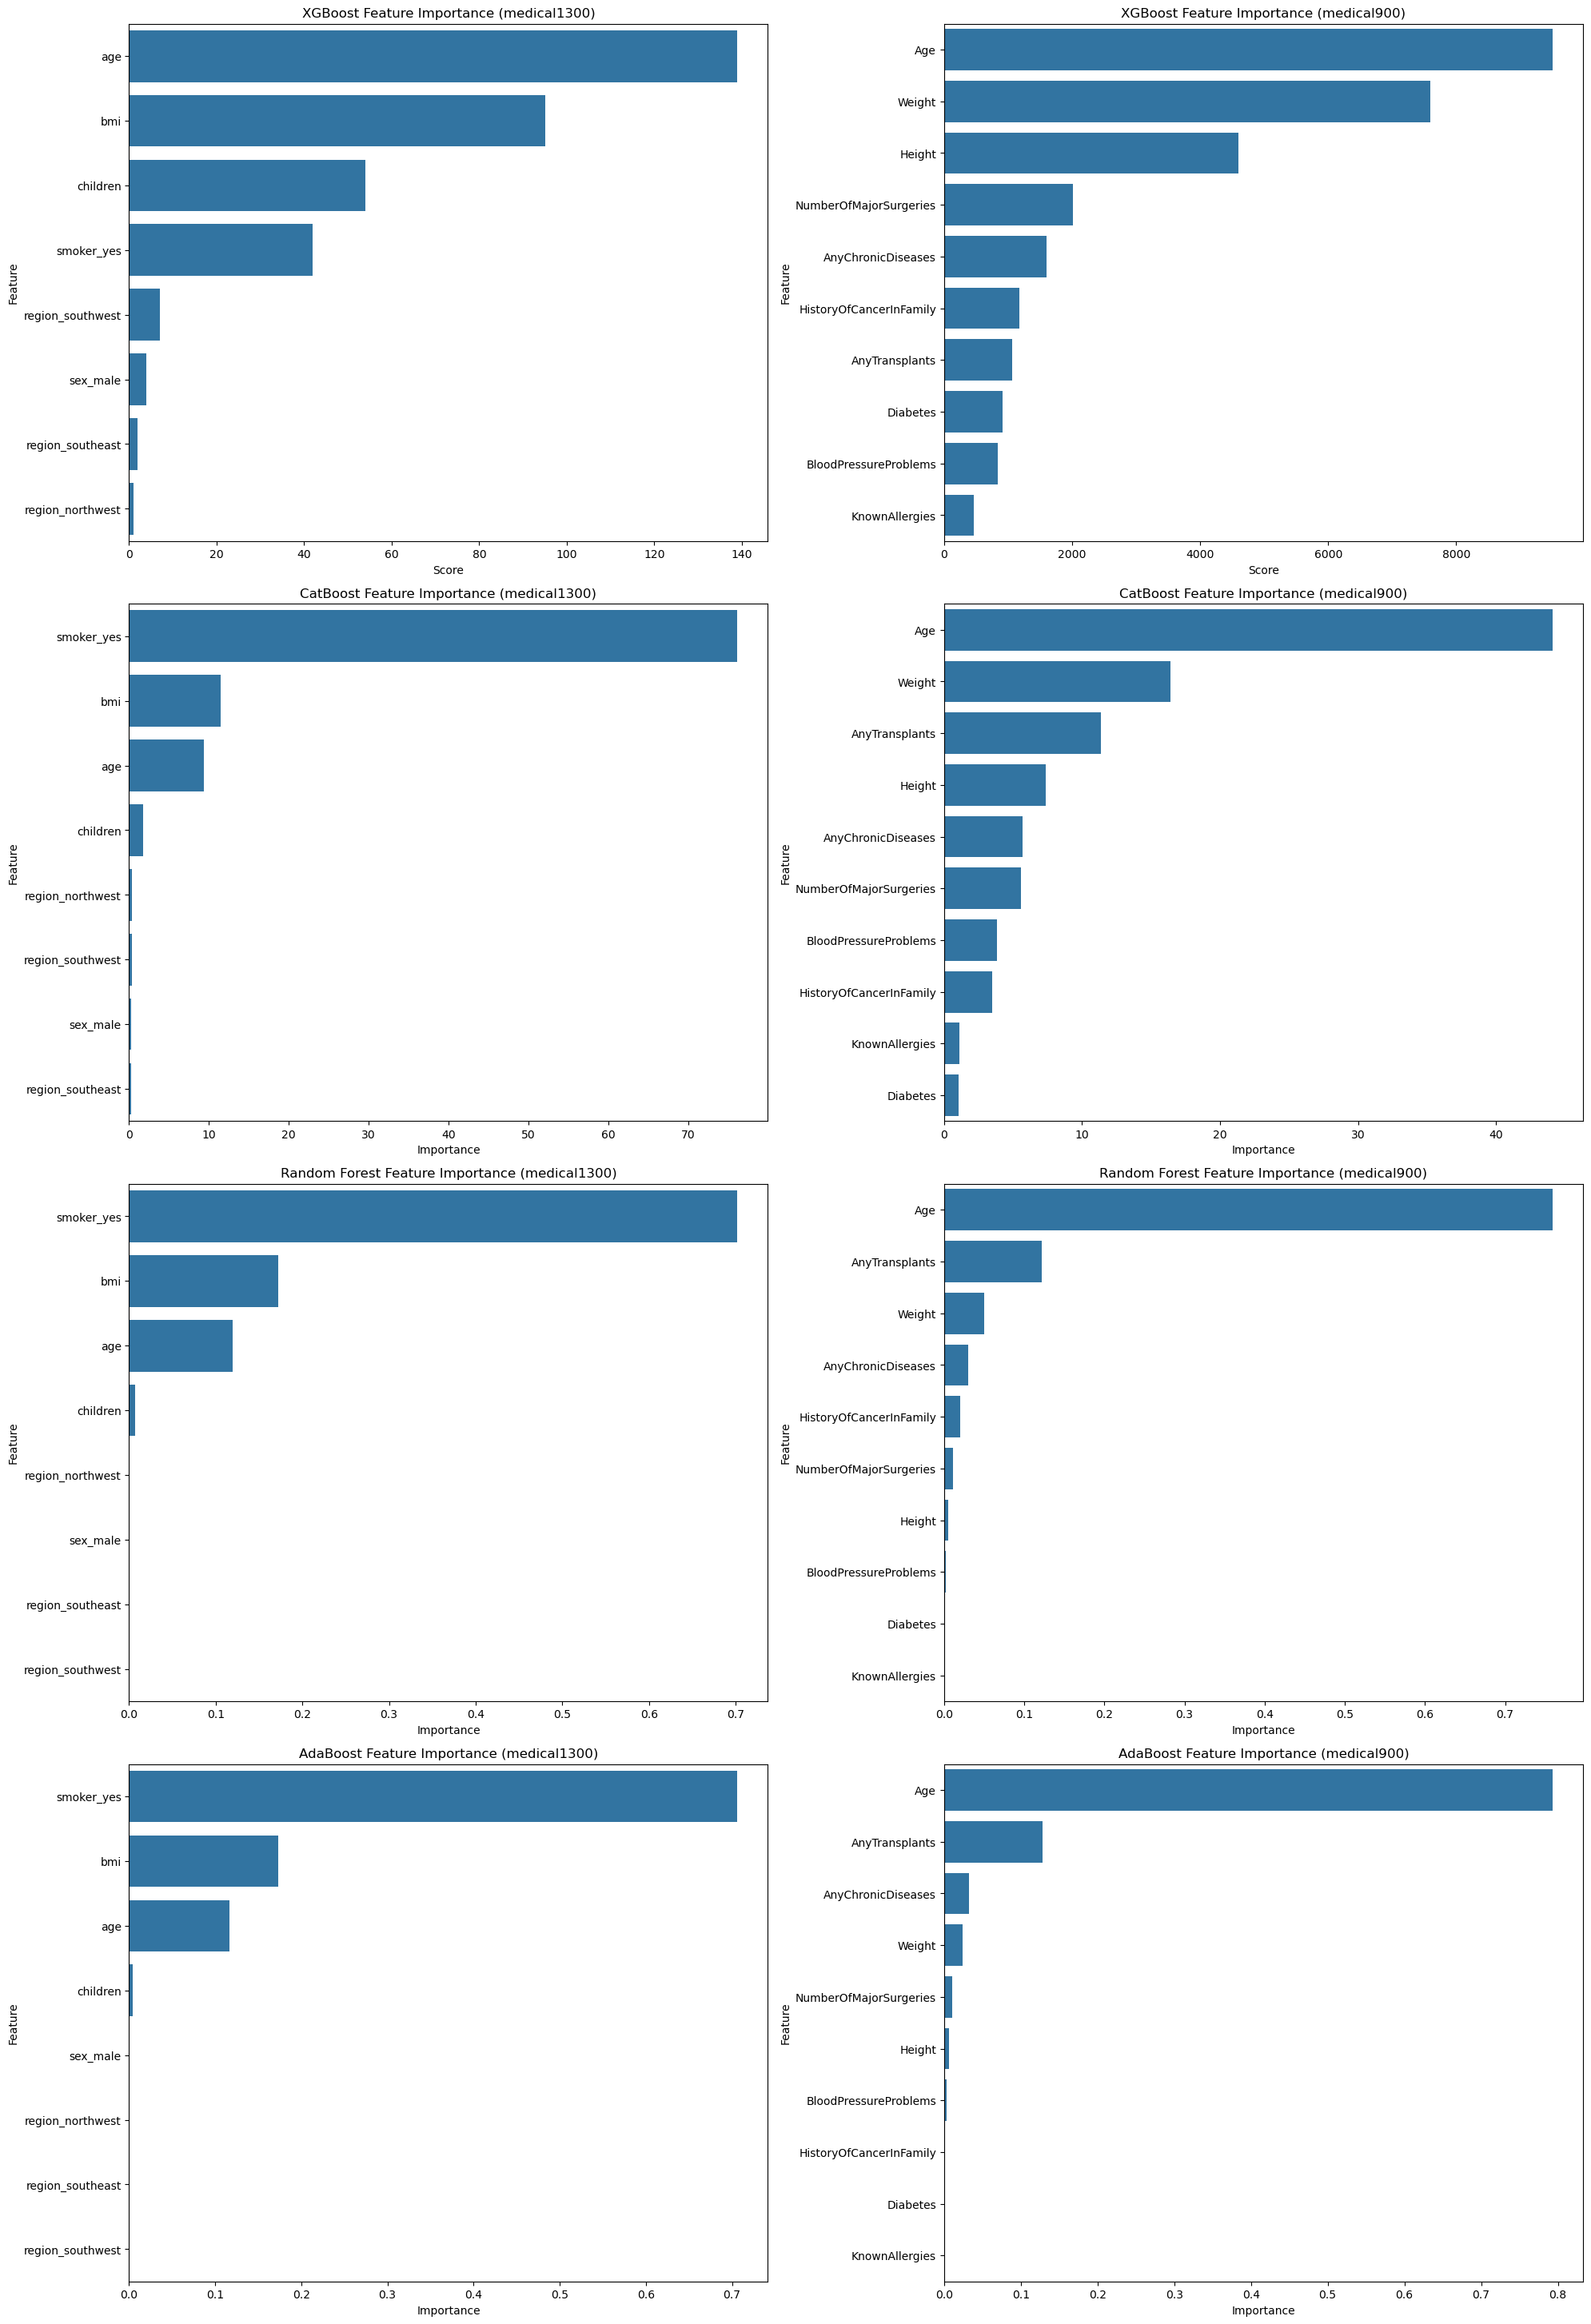

In [120]:
plt.figure(figsize=(20, 36))

# Plot feature importance for medical1300 dataset
plt.subplot(5, 2, 1)
plot_xgb_importance(models_1300['XGBoost'], feature_names_1300, 'XGBoost Feature Importance (medical1300)')
plt.subplot(5, 2, 3)
plot_catboost_importance(models_1300['CatBoost'], feature_names_1300, 'CatBoost Feature Importance (medical1300)')
plt.subplot(5, 2, 5)
plot_sklearn_importance(models_1300['Random Forest'], feature_names_1300, 'Random Forest Feature Importance (medical1300)')
plt.subplot(5, 2, 7)
plot_sklearn_importance(models_1300['AdaBoost'], feature_names_1300, 'AdaBoost Feature Importance (medical1300)')

# Plot feature importance for medical900 dataset
plt.subplot(5, 2, 2)
plot_xgb_importance(models_900['XGBoost'], feature_names_900, 'XGBoost Feature Importance (medical900)')

plt.subplot(5, 2, 4)
plot_catboost_importance(models_900['CatBoost'], feature_names_900, 'CatBoost Feature Importance (medical900)')
plt.subplot(5, 2, 6)
plot_sklearn_importance(models_900['Random Forest'], feature_names_900, 'Random Forest Feature Importance (medical900)')
plt.subplot(5, 2, 8)
plot_sklearn_importance(models_900['AdaBoost'], feature_names_900, 'AdaBoost Feature Importance (medical900)')

plt.tight_layout()
plt.show()

## MODEL EVALUATION METRICS COMPARISON

In [121]:
# Function to plot and compare metrics
def plot_metrics(results, dataset_name):
    metrics = ['MAE', 'MSE', 'RMSE', 'R2']
    models = list(results.keys())

    fig, axes = plt.subplots(4, 1, figsize=(12, 18))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        values = [results[model][metric] for model in models]
        axes[i].bar(models, values, color=['skyblue', 'lightgreen', 'salmon', 'lightblue', 'lightcoral', 'lightpink', 'lightseagreen', 'lightgoldenrodyellow', 'lightsteelblue'])
        axes[i].set_title(f'{metric} Comparison for {dataset_name}')
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel('Model')
        for j, v in enumerate(values):
            axes[i].text(j, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


Metrics Evaluation for medical1300.csv


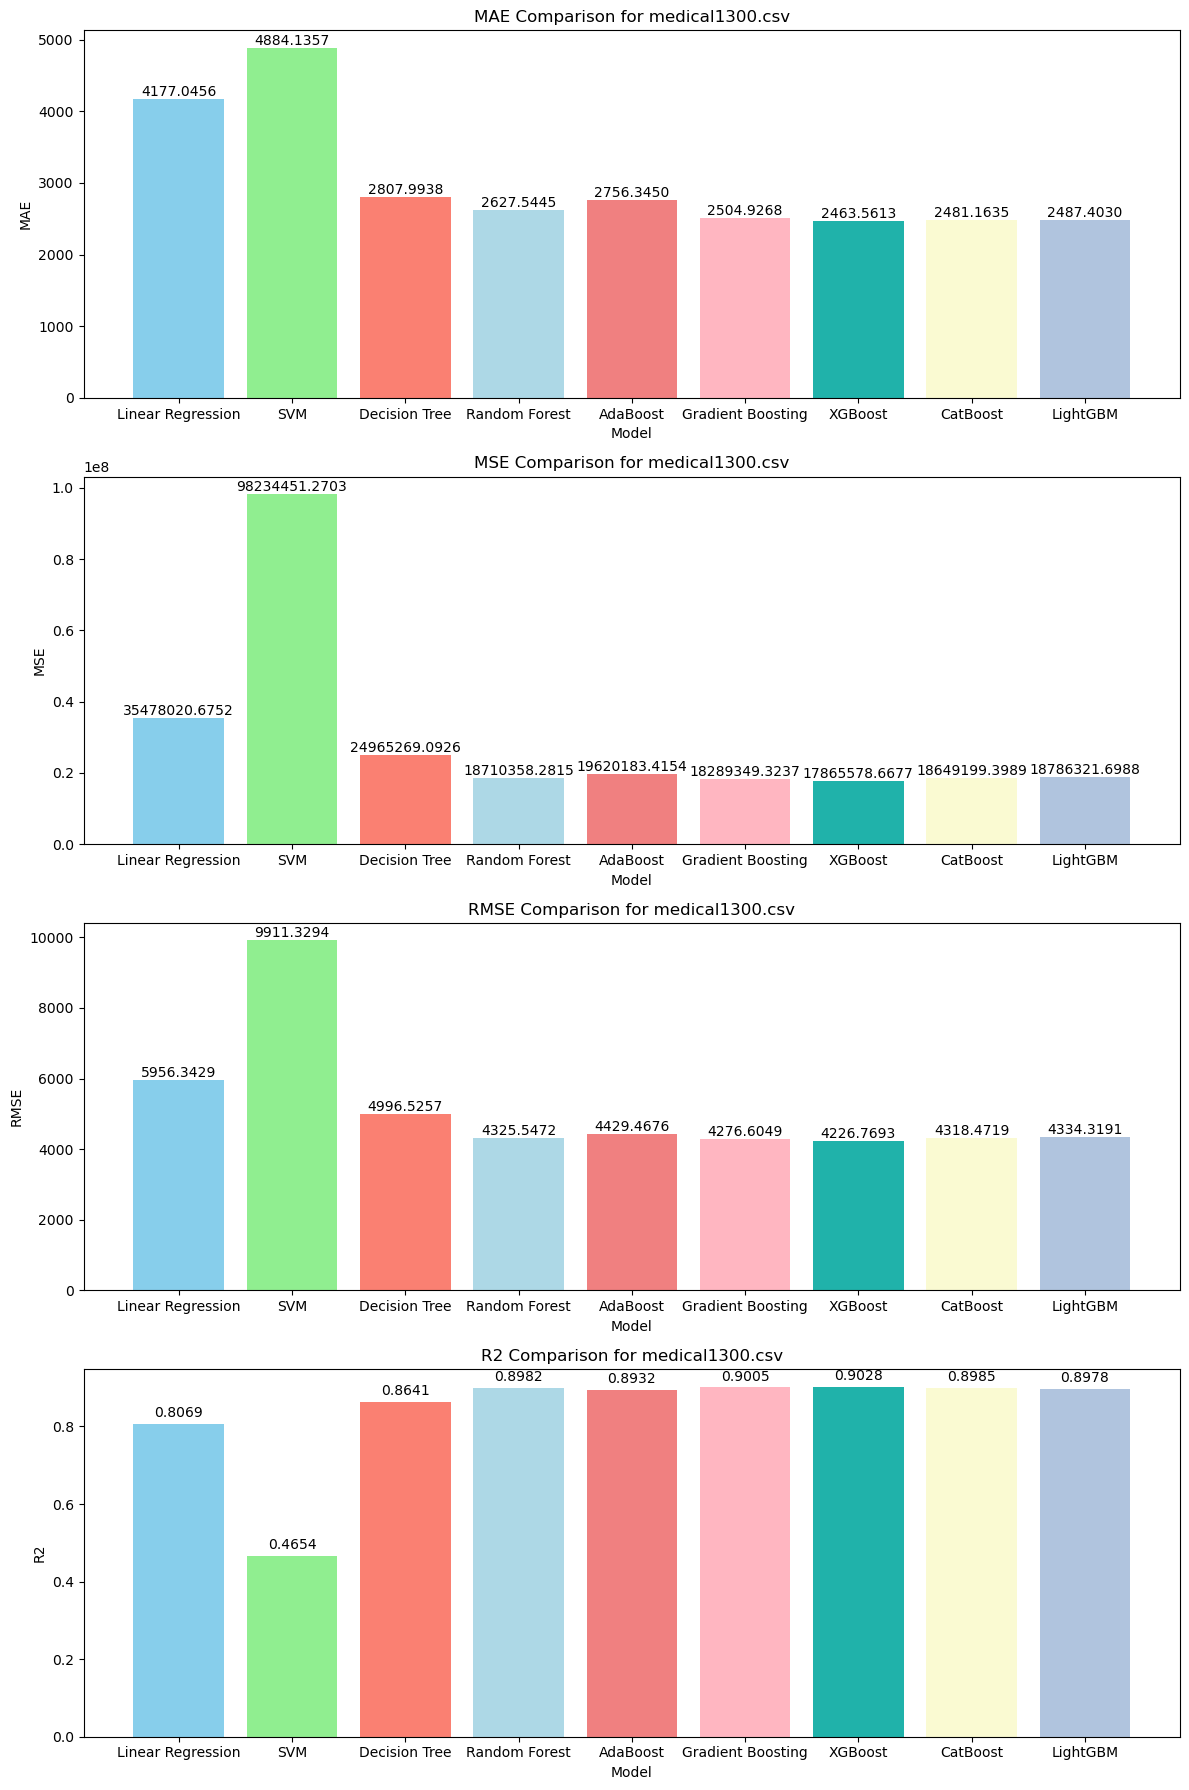

In [122]:
# Load all metrics
linreg_metrics = pickle.load(open('metrics/Linear Regression_1300.pkl', 'rb'))
svm_metrics = pickle.load(open('metrics/SVM_1300.pkl', 'rb'))
dt_metrics = pickle.load(open('metrics/Decision Tree_1300.pkl', 'rb'))
rf_metrics = pickle.load(open('metrics/Random Forest_1300.pkl', 'rb'))
ada_metrics = pickle.load(open('metrics/AdaBoost_1300.pkl', 'rb'))
gb_metrics = pickle.load(open('metrics/Gradient Boosting_1300.pkl', 'rb'))
xgb_metrics = pickle.load(open('metrics/XGBoost_1300.pkl', 'rb'))
catboost_metrics = pickle.load(open('metrics/CatBoost_1300.pkl', 'rb'))
lgbm_metrics = pickle.load(open('metrics/LightGBM_results_1300.pkl', 'rb'))

# Aggregate the loaded metrics
results_1300 = {
    'Linear Regression': linreg_metrics,
    'SVM': svm_metrics,
    'Decision Tree': dt_metrics,
    'Random Forest': rf_metrics,
    'AdaBoost': ada_metrics,
    'Gradient Boosting': gb_metrics,
    'XGBoost': xgb_metrics,
    'CatBoost': catboost_metrics,
    'LightGBM': lgbm_metrics
}

# Plot metrics for medical1300.csv
print("Metrics Evaluation for medical1300.csv")
plot_metrics(results_1300, 'medical1300.csv')


Metrics Evaluation for medical900.csv


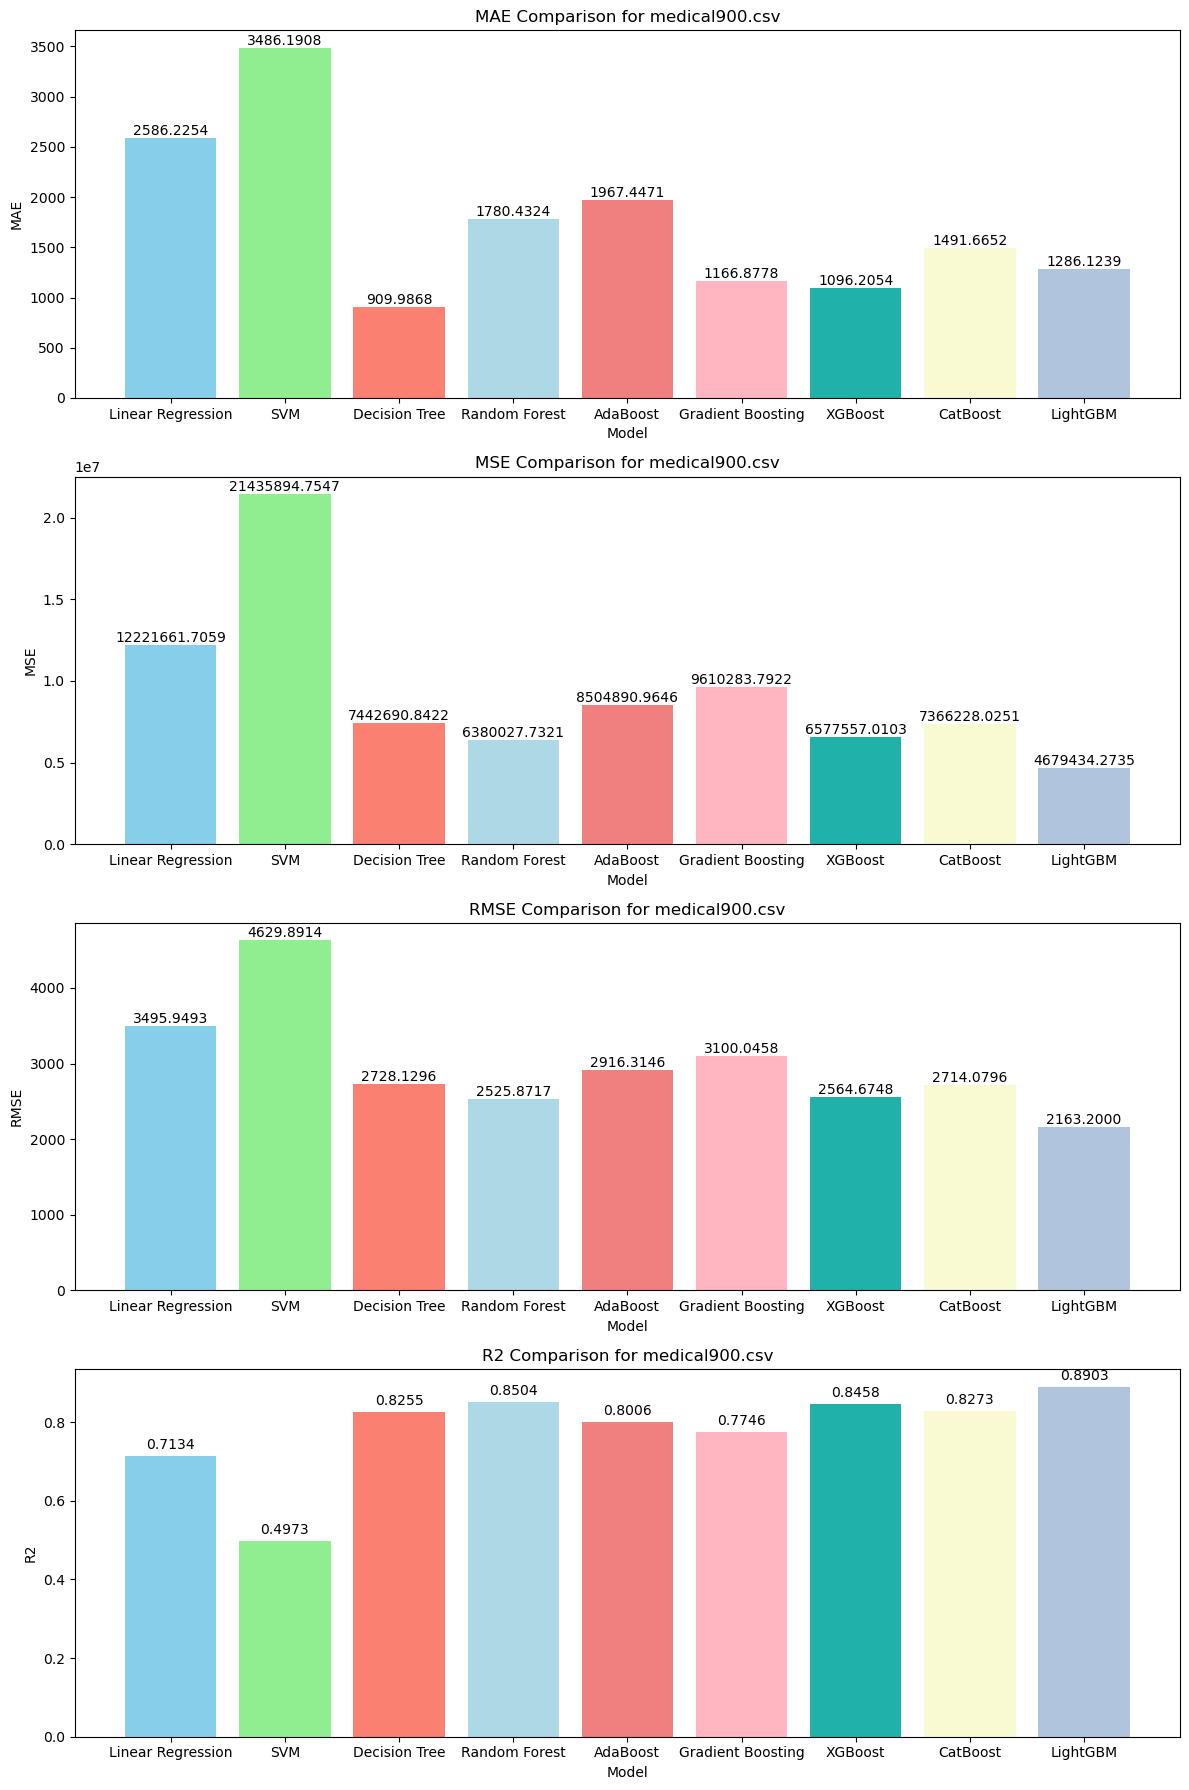

In [123]:
# Load all metrics
linreg_metrics = pickle.load(open('metrics/Linear Regression_900.pkl', 'rb'))
svm_metrics = pickle.load(open('metrics/SVM_900.pkl', 'rb'))
dt_metrics = pickle.load(open('metrics/Decision Tree_900.pkl', 'rb'))
rf_metrics = pickle.load(open('metrics/Random Forest_900.pkl', 'rb'))
ada_metrics = pickle.load(open('metrics/AdaBoost_900.pkl', 'rb'))
gb_metrics = pickle.load(open('metrics/Gradient Boosting_900.pkl', 'rb'))
xgb_metrics = pickle.load(open('metrics/XGBoost_900.pkl', 'rb'))
catboost_metrics = pickle.load(open('metrics/CatBoost_900.pkl', 'rb'))
lgbm_metrics = pickle.load(open('metrics/LightGBM_results_900.pkl', 'rb'))

# Aggregate the loaded metrics
results_900 = {
    'Linear Regression': linreg_metrics,
    'SVM': svm_metrics,
    'Decision Tree': dt_metrics,
    'Random Forest': rf_metrics,
    'AdaBoost': ada_metrics,
    'Gradient Boosting': gb_metrics,
    'XGBoost': xgb_metrics,
    'CatBoost': catboost_metrics,
    'LightGBM': lgbm_metrics
}

# Plot metrics for medical1300.csv
print("Metrics Evaluation for medical900.csv")
plot_metrics(results_900, 'medical900.csv')

# UNUSED CODE

In [ ]:
# # Apply log transformation to handle skewness
# medical1300['charges'] = np.log1p(medical1300['charges'])
# medical900['PremiumPrice'] = np.log1p(medical900['PremiumPrice'])

# # Plot the distribution of the transformed target variable for medical1300 dataset
# plt.figure(figsize=(12, 6))
# sns.histplot(medical1300['charges'], bins=30, kde=True)
# plt.title('Distribution of Transformed Charges in medical1300.csv')
# plt.xlabel('Log(Charges)')
# plt.ylabel('Frequency')
# plt.show()

# # Plot the distribution of the transformed target variable for medical900 dataset
# plt.figure(figsize=(12, 6))
# sns.histplot(medical900['PremiumPrice'], bins=30, kde=True)
# plt.title('Distribution of Transformed PremiumPrice in medical900.csv')
# plt.xlabel('Log(PremiumPrice)')
# plt.ylabel('Frequency')
# plt.show()

# # Define a function for preprocessing
# def preprocess_data(df, target_column):
#     # Check for missing values
#     if df.isnull().sum().sum() > 0:
#         df = df.dropna()

#     # Check for duplicate values
#     df = df.drop_duplicates()

#     # Split features and target
#     X = df.drop(columns=[target_column])
#     y = df[target_column]

#     # One-hot encoding for categorical variables
#     X = pd.get_dummies(X, drop_first=True)

#     # Feature scaling
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)

#     return X, y

# # Preprocess the datasets with transformed target variables
# X_1300, y_1300 = preprocess_data(medical1300, 'charges')
# X_900, y_900 = preprocess_data(medical900, 'PremiumPrice')

# # Split the data into training and testing sets
# X_train_1300, X_test_1300, y_train_1300, y_test_1300 = train_test_split(X_1300, y_1300, test_size=0.2, random_state=42)
# X_train_900, X_test_900, y_train_900, y_test_900 = train_test_split(X_900, y_900, test_size=0.2, random_state=42)

# # Now, you can proceed with the model training, hyperparameter tuning, and evaluation as before

# # Define a function to evaluate models
# def evaluate_model(model, X_train, X_test, y_train, y_test):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     mae = mean_absolute_error(y_test, y_pred)
#     mse = mean_squared_error(y_test, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_test, y_pred)

#     return mae, mse, rmse, r2

# # Define a function for GridSearchCV
# def grid_search_cv(X_train, y_train, X_test, y_test):
#     models = {
#         'XGBoost': XGBRegressor(),
#         'LightGBM': LGBMRegressor(verbose=0),
#         'CatBoost': CatBoostRegressor(verbose=0)
#     }

#     param_grids = {
#         'XGBoost': {
#             'n_estimators': [100, 200],
#             'learning_rate': [0.01, 0.1],
#             'max_depth': [3, 5, 7]
#         },
#         'LightGBM': {
#             'n_estimators': [100, 200],
#             'learning_rate': [0.01, 0.1],
#             'num_leaves': [31, 50]
#         },
#         'CatBoost': {
#             'iterations': [100, 200],
#             'learning_rate': [0.01, 0.1],
#             'depth': [4, 6, 8]
#         }
#     }

#     results = {}

#     for name, model in models.items():
#         grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
#         grid_search.fit(X_train, y_train)
#         best_model = grid_search.best_estimator_

#         mae, mse, rmse, r2 = evaluate_model(best_model, X_train, X_test, y_train, y_test)

#         results[name] = {
#             'MAE': mae,
#             'MSE': mse,
#             'RMSE': rmse,
#             'R2': r2,
#             'Best Params': grid_search.best_params_
#         }

#     return results

# # Define a function for Hyperopt
# def hyperopt_tune(model_class, space, X_train, y_train, X_test, y_test):
#     def objective(params):
#         # Ensure parameters are converted to correct types
#         if 'n_estimators' in params:
#           params['n_estimators'] = int(params['n_estimators'])
#         if 'max_depth' in params:
#             params['max_depth'] = int(params['max_depth'])
#         if 'num_leaves' in params:
#             params['num_leaves'] = int(params['num_leaves'])
#         if 'iterations' in params:
#             params['iterations'] = int(params['iterations'])
#         if 'depth' in params:
#             params['depth'] = int(params['depth'])

#         model = model_class(**params)
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         mae = mean_absolute_error(y_test, y_pred)
#         return {'loss': mae, 'status': STATUS_OK}

#     trials = Trials()
#     best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=np.random.default_rng(42))
#     return best, trials

# # Define hyperparameter spaces for Hyperopt
# xgb_space = {
#     'n_estimators': scope.int(hp.quniform('n_estimators', 100, 200, 1)),
#     'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
#     'max_depth': scope.int(hp.quniform('max_depth', 3, 7, 1))
# }

# lgbm_space = {
#     'n_estimators': scope.int(hp.quniform('n_estimators', 100, 200, 1)),
#     'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
#     'num_leaves': scope.int(hp.quniform('num_leaves', 31, 50, 1))
# }

# catboost_space = {
#     'iterations': scope.int(hp.quniform('iterations', 100, 200, 1)),
#     'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
#     'depth': scope.int(hp.quniform('depth', 4, 8, 1))
# }

# # Evaluate models using GridSearchCV
# results_grid_1300 = grid_search_cv(X_train_1300, y_train_1300, X_test_1300, y_test_1300)
# results_grid_900 = grid_search_cv(X_train_900, y_train_900, X_test_900, y_test_900)

# # Evaluate models using Hyperopt
# xgb_best_1300, _ = hyperopt_tune(XGBRegressor, xgb_space, X_train_1300, y_train_1300, X_test_1300, y_test_1300)
# lgbm_best_1300, _ = hyperopt_tune(LGBMRegressor, lgbm_space, X_train_1300, y_train_1300, X_test_1300, y_test_1300)
# catboost_best_1300, _ = hyperopt_tune(CatBoostRegressor, catboost_space, X_train_1300, y_train_1300, X_test_1300, y_test_1300)

# xgb_best_900, _ = hyperopt_tune(XGBRegressor, xgb_space, X_train_900, y_train_900, X_test_900, y_test_900)
# lgbm_best_900, _ = hyperopt_tune(LGBMRegressor, lgbm_space, X_train_900, y_train_900, X_test_900, y_test_900)
# catboost_best_900, _ = hyperopt_tune(CatBoostRegressor, catboost_space, X_train_900, y_train_900, X_test_900, y_test_900)

# # Compile Hyperopt results
# results_hyperopt_1300 = {
#     'XGBoost': evaluate_model(XGBRegressor(**xgb_best_1300), X_train_1300, X_test_1300, y_train_1300, y_test_1300),
#     'LightGBM': evaluate_model(LGBMRegressor(**lgbm_best_1300), X_train_1300, X_test_1300, y_train_1300, y_test_1300),
#     'CatBoost': evaluate_model(CatBoostRegressor(verbose=0, **catboost_best_1300), X_train_1300, X_test_1300, y_train_1300, y_test_1300)
# }

# results_hyperopt_900 = {
#     'XGBoost': evaluate_model(XGBRegressor(**xgb_best_900), X_train_900, X_test_900, y_train_900, y_test_900),
#     'LightGBM': evaluate_model(LGBMRegressor(**lgbm_best_900), X_train_900, X_test_900, y_train_900, y_test_900),
#     'CatBoost': evaluate_model(CatBoostRegressor(verbose=0, **catboost_best_900), X_train_900, X_test_900, y_train_900, y_test_900)
# }

# # Display the results
# print("GridSearchCV Results for medical1300.csv:")
# for model, metrics in results_grid_1300.items():
#     print(f"\n{model}:")
#     for metric, value in metrics.items():
#         if isinstance(value, dict):
#             print(f"{metric}: {value}")
#         else:
#             print(f"{metric}: {value:.4f}")

# print("\nHyperopt Results for medical1300.csv:")
# for model, metrics in results_hyperopt_1300.items():
#     print(f"\n{model}:")
#     mae, mse, rmse, r2 = metrics
#     print(f"MAE: {mae:.4f}")
#     print(f"MSE: {mse:.4f}")
#     print(f"RMSE: {rmse:.4f}")
#     print(f"R2: {r2:.4f}")

# print("\nGridSearchCV Results for medical900.csv:")
# for model, metrics in results_grid_900.items():
#     print(f"\n{model}:")
#     for metric, value in metrics.items():
#         if isinstance(value, dict):
#             print(f"{metric}: {value}")
#         else:
#             print(f"{metric}: {value:.4f}")

# print("\nHyperopt Results for medical900.csv:")
# for model, metrics in results_hyperopt_900.items():
#     print(f"\n{model}:")
#     mae, mse, rmse, r2 = metrics
#     print(f"MAE: {mae:.4f}")
#     print(f"MSE: {mse:.4f}")
#     print(f"RMSE: {rmse:.4f}")
#     print(f"R2: {r2:.4f}")

